# CS109A Final Project: Data Analysis 
**Harvard University**<br>
**Fall 2016**<br>
**Authors: Kurt Bullard and Kendrick Vinar**<br>

## Outline
1. [Import Packages](#1. Import Packages)
2. [Functions](#2. Functions)
3. [Data Preparation](#3. Data Preparation)
4. [Execution](#4. Execution)




#- [8.1.1 Regression Trees](#8.1.1-Regression-Trees)
#- [8.1.2 Classification Trees](#8.1.2-Classification-Trees)
#- [Lab: 8.3.1 Fitting Classification Trees](#8.3.1-Fitting-Classification-Trees)

# 1. Import Packages

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
from sklearn.linear_model import LinearRegression as Lin_Reg
from sklearn import linear_model
from sklearn import discriminant_analysis
from sklearn import preprocessing
from sklearn import tree
from sklearn import ensemble
from sklearn.cross_validation import KFold
import StringIO
from sklearn.linear_model import LogisticRegression
import matplotlib
import matplotlib.pyplot as plt


import itertools as it
from sklearn.cross_validation import KFold
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.tree import DecisionTreeClassifier as DecisionTree
from sklearn.ensemble import RandomForestClassifier as RandomForest
from sklearn.svm import SVC
from sklearn.cross_validation import train_test_split
from sklearn import svm
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

# 2. Functions 

Below are all the functions used in the data analysis process. 

In [65]:
#
# functions for splitting data on desired predictor/response
#

def split_on_win(data):
    x = data.iloc[:, :-8]
    y = data.loc[:, 'win_or_loss']
    return x, y

def split_on_pt(data):
    x = data.iloc[:, :-8]
    y = data.loc[:, 'pt_diff']
    return x, y

In [3]:
#
# function that returns data for a given year
#
# Inputs: 
#     matrix - the dataset containing all years (NOTE: should be cleaned)
#     desired_years - a list of integers, e.g., [2004, 2005, 2006]
#
# Outputs:
#     

def get_years(matrix, desired_years):
    return matrix.loc[matrix['Year'].isin(desired_years)]



In [4]:
#preds_2015 = prediction_matrix.loc[prediction_matrix['Year'].isin([2015])]

# Get the No. seed from the total seed 

def clean_prediction_matrix(pred_matrix):   
    # removes 'a' or 'b' appended to play-in teams
    for i in range(0, len(pred_matrix)):
        if (len(pred_matrix.ix[i,"team1spot"]) == 4):
            pred_matrix.ix[i,"team1spot"] = pred_matrix.ix[i,"team1spot"][0:3]
        if (len(pred_matrix.ix[i,"team2spot"]) == 4):
            pred_matrix.ix[i,"team2spot"] = pred_matrix.ix[i,"team2spot"][0:3]
    
    return pred_matrix

#
# Resets index of matrix, needed after taking excerpt from original matrix
#

def reset_index(pred_matrix):
    pred_matrix = pred_matrix.reset_index(drop = True)
    return pred_matrix

In [5]:
#
# Input:
#     df - dataframe containing prediction matrix of a given year (e.g., preds_2015)
#          also, is the result of the get_years function
#
# Output: 
#     d - dictionary mapping team codes (e.g., W13) to a list of predictors 
#

def dictionary_gen (df):
    # first want a new df that only has round 1 results
    # because all 64 teams play in the first round
    rd_1_results = df.loc[df['round'] == 1]
    
    # create an empty list
    the_list = []
    
    for index, row in rd_1_results.iterrows():
        # for each row, appends a tuple of the unique code
        # and the values that correspond to that team
        
        # NOTE: if this shape of the dataframe passed changes
        #       these indicies will be invalid
        the_list.append([row['team1spot'], row.iloc[:15]])
        the_list.append([row['team2spot'], row.iloc[15:30]])
        
    # create a dictionary
    d = dict(the_list)
    
    return d
    
        
    
    

In [6]:
# This function recreates the shape of the original training data for each possible
# tournament matchup, allowing for a trained model to be used to make predictions
#
# Input: 
#     pred_matrix - prediction matrix for a given year (e.g., preds_2015)
#     predictors - dictionary mapping team seeding codes to their predictors
#
# Output: 
#     preds_all_games_final - dataframe containing predictors for each possible matchup



def matchups_matrix(pred_matrix, predictors):
    # creates dataframe to hold all possible seed matchups
    preds_all_games = pd.DataFrame(np.zeros((64**2,2)))

    # creates counter for indexing
    count = 0
    
    # inserts all possible combinations of seeds into preds_all_games
    for i in range(len(predictors.keys())):
        for j in range(len(predictors.keys())):
            preds_all_games.ix[count,0] = predictors.keys()[i]
            preds_all_games.ix[count,1] = predictors.keys()[j]
            count = count + 1
    
    # creates two new dataframes to hold predictors for each team
    favorites = pd.DataFrame(np.zeros((64**2,15)))
    underdogs = pd.DataFrame(np.zeros((64**2,15)))

    # retrieves predictors for the favorites and underdogs
    for i in range(0,64**2):
        favorites.iloc[i,:] = pd.Series(predictors[preds_all_games.iloc[i,0]]).values
        underdogs.iloc[i,:] = pd.Series(predictors[preds_all_games.iloc[i,1]]).values
    
    
    interaction_terms = pd.DataFrame(np.zeros((64**2,2)))
    for i in range(0,64**2):
        interaction_terms.iloc[i,0] = favorites.iloc[i,12] * underdogs.iloc[i,11]
        interaction_terms.iloc[i,1] = underdogs.iloc[i,12] * favorites.iloc[i,11]
        #interaction_terms.iloc[i,2] =  favorites.iloc[i,13] * underdogs.iloc[i,13]    
        #interaction_terms.iloc[i,3] = favorites.iloc[i,14] * underdogs.iloc[i,15]    
        #interaction_terms.iloc[i,4] = favorites.iloc[i,15] * underdogs.iloc[i,14]
    # concatenates all dataframes together
    preds_all_games_final = pd.concat([preds_all_games, favorites, underdogs,
                                            interaction_terms], axis=1)
    
    # renames columns
    preds_all_games_final.columns = ["favorite", "underdog",'team1tofor', 'team1drratiofor', 'team1orratiofor', 
'team1pot3ptsfor',
 'team1potftptsfor', 'team1toag' ,'team1drratioag', 'team1orratioag',
 'team1pot3ptsag' ,'team1potftptsag', 'team1kentempo' ,'team1drank',
 'team1orank',
#'team1seed', 
'team1goodwins', 'team1goodlosses', 'team2tofor',
 'team2drratiofor', 'team2orratiofor', 'team2pot3ptsfor' ,'team2potftptsfor',
 'team2toag' ,'team2drratioag', 'team2orratioag' ,'team2pot3ptsag',
 'team2potftptsag', 'team2kentempo' ,'team2drank', 'team2orank', 
#'team2seed',
 'team2goodwins' ,'team2goodlosses', 'team1orank+team2drank',
 'team2orank+team1drank']
#,'team1seed+team2seed'

    
    return preds_all_games_final

In [7]:
# create list of seeds to represent bracket shape
seeds = ['W01','W16','W08','W09','W04','W13','W05','W12','W06','W11','W03','W14','W07','W10','W02','W15',
         'X01','X16','X08','X09','X04','X13','X05','X12','X06','X11','X03','X14','X07','X10','X02','X15',
         'Y01','Y16','Y08','Y09','Y04','Y13','Y05','Y12','Y06','Y11','Y03','Y14','Y07','Y10','Y02','Y15',
         'Z01','Z16','Z08','Z09','Z04','Z13','Z05','Z12','Z06','Z11','Z03','Z14','Z07','Z10','Z02','Z15']

#
# Input:
#     seeds - ordered list of tournament seeds
#     pred_matrix - prediction matrix for a single year (e.g., preds_2015)
#
# Output: 
#     df - dataframe containing paired seeding and team names

def seed_and_name(seeds, pred_matrix):
    # creates an empty dataframe to map seeds to the name of the tournament
    df = pd.DataFrame(np.zeros((64,2)))


    df.iloc[:,0] = seeds

    for i in range(64):
        try:
            df.iloc[i,1] = pred_matrix['team1name'][pred_matrix['team1spot']==df.iloc[i,0]].values[0]
        except IndexError:
            df.iloc[i,1] = pred_matrix['team2name'][pred_matrix['team2spot']==df.iloc[i,0]].values[0]
        
    return df

In [37]:

#
#
# Input:
#     pred_matrix - dataframe containing predictors for all possible matchups in a given year,
#                   output of matchups_matrix
#     train_data - predictors on which to train our model, likely over 7 year span
#     test_data - responses on which to train our model
#
# Output: 
#     pred_matrix - returns same dataframe with new column for predicted win probabilities 



def damn_adventure_time(pred_matrix, train_data, test_data, c):
    # creates list for holding predictions

    pred_matrix2 = pred_matrix
    
    predictions_list = []
    
    # remove first two columns containing team codes
    # leaves only predictors
    predictors = pred_matrix.iloc[:, 2:]
    
    # create a logistic model
    logistic_model = LogisticRegression(C = c)
    
    # fits model on the datas
    logistic_model.fit(train_data, test_data)
    
    coef_matrix = logistic_model.coef_
    
    pred_matrix2['prediction'] = logistic_model.predict_proba(predictors)[:,1]
    
    return pred_matrix2, coef_matrix
    
def damn_adventure_time_svm(pred_matrix, train_data, test_data, c):
    # creates list for holding predictions

    pred_matrix2 = pred_matrix
    
    predictions_list = []
    
    # remove first two columns containing team codes
    # leaves only predictors
    predictors = pred_matrix.iloc[:, 2:]
    
    # create an SVM model
    svm_model = sklearn.svm.SVC(C = c, probability = True, kernel='linear')
    
    # fits model on the datas
    svm_model.fit(train_data, test_data)
    
    coef_matrix = svm_model.coef_
    
    pred_matrix2['prediction'] = svm_model.predict_proba(predictors)[:,1]
    
    return pred_matrix2, coef_matrix

def damn_adventure_time_rf(pred_matrix, train_data, test_data, max_f,  max_d):
    # creates list for holding predictions

    pred_matrix2 = pred_matrix
    
    predictions_list = []
    
    # remove first two columns containing team codes
    # leaves only predictors
    predictors = pred_matrix.iloc[:, 2:]
    
    rf = ensemble.RandomForestClassifier(n_estimators=200, max_features = max_f, max_depth = max_d)
    rf.fit(train_data, test_data)

    coef_matrix = rf.feature_importances_
    
    pred_matrix2['prediction'] = rf.predict_proba(predictors)[:,1] 
    
    # fits model on the datas
    
    return pred_matrix2, coef_matrix

In [9]:
# Predicts winners of given round of tournament
#
# Input:
#     pred_matrix - output of damn_adventure_time
#     seeds - pre-formatted list of tournament seeds
#     seed_to_name - output of seed_and_name
#     risk - float value between 0.0 and 1.0, 
#            functions as the decision boundary for choosing teams
#            e.g., value of 0.6 says you have to believe favorite is likely to win
#            with at least 60% likelihood in order to predict the favorite to advance


def pick_winners_new(pred_matrix, seeds, seed_to_name, risk):
    # counter to track the number of upsets
    upsets = 0
    
    # checks for valid risk entry
    if ((risk > 1) | (risk < 0)):
        return 0
    
    # creates list to hold winners of this round
    winners = []
    
    
    for i in range(0,len(seeds)-1,2):
        
        if(int(seeds[i][-2:]) > int(seeds[i+1][-2:])):
            # adds favorite as winner
            if(pred_matrix['prediction'][(pred_matrix.iloc[:,1] == seeds[i]) & (pred_matrix.iloc[:,0] == seeds[i+1])].values[0] > float(risk)):
                winners.append(seeds[i+1])
            # adds underdog as winner
            else:
                winners.append(seeds[i])
                upsets = upsets + 1
        # not exactly sure what this branch is doing
        else:
            if(pred_matrix['prediction'][(pred_matrix.iloc[:,0] == seeds[i]) & (pred_matrix.iloc[:,1] == seeds[i+1])].values[0] > float(risk)):
                winners.append(seeds[i])
            else:
                winners.append(seeds[i+1])
                upsets = upsets + 1
    
    # create list to hold name of round winners
    winners_name = []
    
    
    for i in range(len(winners)):
        winners_name.append(seed_to_name.iloc[:,1][seed_to_name.iloc[:,0] == winners[i]].values[0])
    
    print winners_name
    #print "There were",upsets,"upsets"
    return winners
           

In [10]:
#
# function that returns likelihood each team wins given a model
#
# Inputs:
#     model - a trained predictive model, probably a logistic model
#     data - the data use to predict likelihood of a win
#
# Outputs: 
#     low_seed_win - likelihood that the better team wins
#     high_seed_win - likelihood that the worse team wins


def head_to_head(model, predictors):
    low_seed_win = model.predict_proba(predictors)[1]
    high_seed_win = model.predict_proba(predictors)[0]
    
    return low_seed_win, high_seed_win

# 3. Data Preparation

In order to train a variety of models, we have to split up the datasets.

In [71]:
prediction_matrix = pd.read_csv("pred_matrix2.csv")

# these are for predicting the future, and creating matchups
matrix_2003_2009 = clean_prediction_matrix(reset_index(get_years(prediction_matrix,[2003, 2004, 2005, 2006, 2007, 2008, 2009])))
matrix_2004_2010 = clean_prediction_matrix(reset_index(get_years(prediction_matrix,[2004, 2005, 2006, 2007, 2008, 2009, 2010])))
matrix_2005_2011 = clean_prediction_matrix(reset_index(get_years(prediction_matrix,[2005, 2006, 2007, 2008, 2009, 2010, 2011])))
matrix_2006_2012 = clean_prediction_matrix(reset_index(get_years(prediction_matrix,[2006, 2007, 2008, 2009, 2010, 2011, 2012])))
matrix_2007_2013 = clean_prediction_matrix(reset_index(get_years(prediction_matrix,[2007, 2008, 2009, 2010, 2011, 2012, 2013])))
matrix_2008_2014 = clean_prediction_matrix(reset_index(get_years(prediction_matrix,[2008, 2009, 2010, 2011, 2012, 2013, 2014])))
matrix_2009_2015 = clean_prediction_matrix(reset_index(get_years(prediction_matrix,[2009, 2010, 2011, 2012, 2013, 2014, 2015])))


In [72]:
# these are for training the model, not predicting the future
predictors_2003_2009, response_2003_2009 = split_on_win(matrix_2003_2009)
predictors_2004_2010, response_2004_2010 = split_on_win(matrix_2004_2010)
predictors_2005_2011, response_2005_2011 = split_on_win(matrix_2005_2011)
predictors_2006_2012, response_2006_2012 = split_on_win(matrix_2006_2012)
predictors_2007_2013, response_2007_2013 = split_on_win(matrix_2007_2013)
predictors_2008_2014, response_2008_2014 = split_on_win(matrix_2008_2014)
predictors_2009_2015, response_2009_2015 = split_on_win(matrix_2009_2015)


In [73]:
# these are matrices for individual years from 2008 - 2016
matrix_2010 = clean_prediction_matrix(reset_index(get_years(prediction_matrix,[2010])))
matrix_2011 = clean_prediction_matrix(reset_index(get_years(prediction_matrix,[2011])))
matrix_2012 = clean_prediction_matrix(reset_index(get_years(prediction_matrix,[2012])))
matrix_2013 = clean_prediction_matrix(reset_index(get_years(prediction_matrix,[2013])))
matrix_2014 = clean_prediction_matrix(reset_index(get_years(prediction_matrix,[2014])))
matrix_2015 = clean_prediction_matrix(reset_index(get_years(prediction_matrix,[2015])))


In [74]:
_, response_2010 = split_on_win(matrix_2010)
_, response_2011 = split_on_win(matrix_2011)
_, response_2012 = split_on_win(matrix_2012)
_, response_2013 = split_on_win(matrix_2013)
_, response_2014 = split_on_win(matrix_2014)
_, response_2015 = split_on_win(matrix_2015)


In [75]:
pred_matrices_train = [predictors_2003_2009,
                       predictors_2004_2010,
                       predictors_2005_2011,
                       predictors_2006_2012,
                       predictors_2007_2013,
                       predictors_2008_2014]


response_train = [response_2003_2009,
                 response_2004_2010,
                 response_2005_2011,
                 response_2006_2012,
                 response_2007_2013,
                 response_2008_2014]

response_test = [response_2010,
                 response_2011,
                 response_2012,
                 response_2013,
                 response_2014]

# 4. Execution

In [76]:
# read in prediction matrix


# cleans original file, removing a's and b's from seeds
cleaned_prediction_matrix = clean_prediction_matrix(prediction_matrix)

def set_up_games(year):
    

    # retrieves 2015 data from cleaned prediction matrix
    preds = get_years(cleaned_prediction_matrix, [year])

    # resets index on matrix
    preds = reset_index(preds)

    # creates dictionary mapping team codes for that year to their predictors
    dict_ = dictionary_gen(preds)

    # creates dataframe containing predictors for each possible matchup
    #
    # QUESTION: is it okay that there are faulty rows where the favorite is labeled 
    #           as the higher seed? I assume we will never index into these rows?
    #

    matchups = matchups_matrix(preds, dict_)

    # pairs seed code (e.g., W01) to team name (e.g., Villanova)
    bracket = seed_and_name(seeds, preds)
    
    return preds, dict_, matchups, bracket




In [77]:
def pick_a_bracket(predictions_for_testing, seeds, bracket, risk, matrix_year):

    round1winners = pick_winners_new(predictions_for_testing, seeds, bracket, risk)
    round2winners = pick_winners_new(predictions_for_testing, round1winners, bracket, risk)
    round3winners = pick_winners_new(predictions_for_testing, round2winners, bracket, risk)
    round4winners = pick_winners_new(predictions_for_testing, round3winners, bracket, risk)
    round5winners = pick_winners_new(predictions_for_testing, round4winners, bracket, risk)
    round6winners = pick_winners_new(predictions_for_testing, round5winners, bracket, risk)
    
    pred_winners = pd.Series(np.concatenate((round1winners,round2winners,round3winners,round4winners,round5winners,round6winners),axis=0))

    games_played = pd.concat([matrix_year['team1spot'], matrix_year['team2spot']], axis = 0)

    games_won_by_team_2015 = games_played.value_counts()-1

    preds_won_by_team_2015 = pred_winners.value_counts()

    actual_and_prediction_wins = pd.concat([games_won_by_team_2015, preds_won_by_team_2015], axis=1)

    actual_and_prediction_wins = actual_and_prediction_wins.fillna(0)

    right_predictions = 0
    score_bracket = 0
    for i in range(len(actual_and_prediction_wins)):
        right_predictions = right_predictions + np.min(actual_and_prediction_wins.iloc[i,:])
        score_add = 0
        if (np.min(actual_and_prediction_wins.iloc[i,:])>0):
            for j in range(int(np.min(actual_and_prediction_wins.iloc[i,:]))):
                score_add = 2**j + score_add
            score_bracket = score_bracket + score_add
    

    print 'The amount of correct predictions is', right_predictions
    print 'The score of the bracket was', score_bracket
    
    return score_bracket

In [78]:
preds_2015, dict_2015, matchups_2015, bracket_2015 = set_up_games(2015)
preds_2014, dict_2014, matchups_2014, bracket_2014 = set_up_games(2014)
preds_2013, dict_2013, matchups_2013, bracket_2013 = set_up_games(2013)
preds_2012, dict_2012, matchups_2012, bracket_2012 = set_up_games(2012)
preds_2011, dict_2011, matchups_2011, bracket_2011 = set_up_games(2011)
preds_2010, dict_2010, matchups_2010, bracket_2010 = set_up_games(2010)


In [20]:
print matchups_2015.shape
print predictors_2008_2014.shape
print response_2008_2014.shape

(4096, 34)
(441, 32)
(441,)


In [24]:
import sklearn

param_scores_log = np.zeros((1,15))
param_scores_svm = np.zeros((1,15))

for i in range(-12,2):

    predictions_for_testing12, coef_matrix12 = damn_adventure_time(matchups_2012.iloc[:,range(32+2)], predictors_2005_2011, response_2005_2011, 10**i)
    predictions_for_testing11, coef_matrix11 = damn_adventure_time(matchups_2011.iloc[:,range(32+2)], predictors_2004_2010, response_2004_2010, 10**i)
    predictions_for_testing10, coef_matrix10 = damn_adventure_time(matchups_2010.iloc[:,range(32+2)], predictors_2003_2009, response_2003_2009, 10**i)
    
    param_scores_log[0,i+11] = pick_a_bracket(predictions_for_testing12, seeds, bracket_2012, .5, matrix_2012) + pick_a_bracket(predictions_for_testing11, seeds, bracket_2011, .5, matrix_2011) + pick_a_bracket(predictions_for_testing10, seeds, bracket_2010, .5, matrix_2010)

    
    predictions_for_testing12_svm, coef_matrix12_svm = damn_adventure_time_svm(matchups_2012.iloc[:,range(32+2)], predictors_2005_2011, response_2005_2011,  10**i)
    predictions_for_testing11_svm, coef_matrix11_svm = damn_adventure_time_svm(matchups_2011.iloc[:,range(32+2)], predictors_2004_2010, response_2004_2010, 10**i)
    predictions_for_testing10_svm, coef_matrix10_svm = damn_adventure_time_svm(matchups_2010.iloc[:,range(32+2)], predictors_2003_2009, response_2003_2009, 10**i)
    
    param_scores_svm[0,i+11] = pick_a_bracket(predictions_for_testing12_svm, seeds, bracket_2012, .5, matrix_2012) + pick_a_bracket(predictions_for_testing11_svm, seeds, bracket_2011, .5, matrix_2011) + pick_a_bracket(predictions_for_testing10_svm, seeds, bracket_2010, .5, matrix_2010)

['Syracuse', 'Kansas St.', 'Wisconsin', 'Harvard', 'Texas', 'Florida St.', 'West Virginia', 'Ohio St.', 'North Carolina', 'Alabama', 'Michigan', 'South Florida', 'North Carolina St.', 'Georgetown', 'Purdue', 'Kansas', 'Kentucky', 'Connecticut', 'Indiana', 'Wichita St.', 'UNLV', 'Baylor', 'Xavier', 'Duke', 'Michigan St.', 'Saint Louis', 'Louisville', 'New Mexico', 'Murray St.', 'Marquette', 'Virginia', 'Missouri']
['Syracuse', 'Harvard', 'Florida St.', 'Ohio St.', 'North Carolina', 'South Florida', 'North Carolina St.', 'Purdue', 'Kentucky', 'Indiana', 'Baylor', 'Xavier', 'Michigan St.', 'Louisville', 'Marquette', 'Virginia']
['Syracuse', 'Ohio St.', 'North Carolina', 'North Carolina St.', 'Kentucky', 'Baylor', 'Michigan St.', 'Virginia']
['Ohio St.', 'North Carolina', 'Kentucky', 'Virginia']
['Ohio St.', 'Virginia']
['Virginia']
The amount of correct predictions is 39.0
The score of the bracket was 79
['Ohio St.', 'Villanova', 'Princeton', 'West Virginia', 'Marquette', 'Syracuse', 'Was

In [25]:
print param_scores_log
print param_scores_svm

[[ 182.  182.  182.  182.  182.  182.  182.  182.  202.  217.  214.  221.
   220.    0.  182.]]
[[ 207.  207.  207.  220.  220.  217.  206.  207.  207.  207.  207.  207.
   207.    0.  207.]]


In [40]:
import sklearn

param_scores_rf = np.zeros((7,5))

max_d  = range(1,8)

max_f = [4,7,10,13,16]

for j in max_d:
    count = 0
    for i in max_f:

        predictions_for_testing12_rf, importance12 = damn_adventure_time_rf(matchups_2012.iloc[:,range(32+2)], predictors_2005_2011, response_2005_2011, max_f[count], max_d[j-1])
        predictions_for_testing11_rf, importance11 = damn_adventure_time_rf(matchups_2011.iloc[:,range(32+2)], predictors_2004_2010, response_2004_2010, max_f[count], max_d[j-1])
        predictions_for_testing10_rf, importance10 = damn_adventure_time_rf(matchups_2010.iloc[:,range(32+2)], predictors_2003_2009, response_2003_2009, max_f[count], max_d[j-1])

        param_scores_rf[j-1,count] = pick_a_bracket(predictions_for_testing12_rf, seeds, bracket_2012, .5, matrix_2012) + pick_a_bracket(predictions_for_testing11_rf, seeds, bracket_2011, .5, matrix_2011) + pick_a_bracket(predictions_for_testing10_rf, seeds, bracket_2010, .5, matrix_2010)
        count = count + 1

    
    



['Syracuse', 'Kansas St.', 'Wisconsin', 'Vanderbilt', 'Cincinnati', 'Florida St.', 'Gonzaga', 'Ohio St.', 'North Carolina', 'Creighton', 'Michigan', 'Temple', 'San Diego St.', 'Georgetown', "Saint Mary's", 'Kansas', 'Kentucky', 'Iowa St.', 'Indiana', 'Wichita St.', 'UNLV', 'Baylor', 'Notre Dame', 'Duke', 'Michigan St.', 'Memphis', 'Louisville', 'New Mexico', 'Murray St.', 'Marquette', 'Florida', 'Missouri']
['Syracuse', 'Wisconsin', 'Florida St.', 'Ohio St.', 'North Carolina', 'Michigan', 'Georgetown', 'Kansas', 'Kentucky', 'Indiana', 'Baylor', 'Duke', 'Michigan St.', 'Louisville', 'Marquette', 'Missouri']
['Syracuse', 'Ohio St.', 'North Carolina', 'Kansas', 'Kentucky', 'Duke', 'Michigan St.', 'Missouri']
['Syracuse', 'North Carolina', 'Kentucky', 'Michigan St.']
['Syracuse', 'Kentucky']
['Syracuse']
The amount of correct predictions is 40.0
The score of the bracket was 88
['Ohio St.', 'George Mason', 'Kentucky', 'West Virginia', 'Xavier', 'Syracuse', 'Washington', 'North Carolina', 'D

In [41]:
param_scores_rf

array([[ 207.,  207.,  207.,  207.,  207.],
       [ 207.,  207.,  207.,  207.,  207.],
       [ 207.,  207.,  207.,  207.,  207.],
       [ 207.,  207.,  207.,  207.,  207.],
       [ 207.,  207.,  207.,  204.,  207.],
       [ 207.,  204.,  205.,  215.,  201.],
       [ 207.,  208.,  202.,  208.,  205.]])

In [26]:
import sklearn

predictions_for_testing15, coef_matrix15 = damn_adventure_time(matchups_2015.iloc[:,range(32+2)], predictors_2008_2014, response_2008_2014, .1)
predictions_for_testing14, coef_matrix14 = damn_adventure_time(matchups_2014.iloc[:,range(32+2)], predictors_2007_2013, response_2007_2013, .1)
predictions_for_testing13, coef_matrix13 = damn_adventure_time(matchups_2013.iloc[:,range(32+2)], predictors_2006_2012, response_2006_2012, .1)
predictions_for_testing12, coef_matrix12 = damn_adventure_time(matchups_2012.iloc[:,range(32+2)], predictors_2005_2011, response_2005_2011, .1)
predictions_for_testing11, coef_matrix11 = damn_adventure_time(matchups_2011.iloc[:,range(32+2)], predictors_2004_2010, response_2004_2010, .1)
predictions_for_testing10, coef_matrix10 = damn_adventure_time(matchups_2010.iloc[:,range(32+2)], predictors_2003_2009, response_2003_2009, .1)

predictions_for_testing15_svm, coef_matrix15_svm = damn_adventure_time_svm(matchups_2015.iloc[:,range(32+2)], predictors_2008_2014, response_2008_2014, 10**-7)
predictions_for_testing14_svm, coef_matrix14_svm = damn_adventure_time_svm(matchups_2014.iloc[:,range(32+2)], predictors_2007_2013, response_2007_2013, 10**-7)
predictions_for_testing13_svm, coef_matrix13_svm = damn_adventure_time_svm(matchups_2013.iloc[:,range(32+2)], predictors_2006_2012, response_2006_2012, 10**-7)
predictions_for_testing12_svm, coef_matrix12_svm = damn_adventure_time_svm(matchups_2012.iloc[:,range(32+2)], predictors_2005_2011, response_2005_2011, 10**-7)
predictions_for_testing11_svm, coef_matrix11_svm = damn_adventure_time_svm(matchups_2011.iloc[:,range(32+2)], predictors_2004_2010, response_2004_2010, 10**-7)
predictions_for_testing10_svm, coef_matrix10_svm = damn_adventure_time_svm(matchups_2010.iloc[:,range(32+2)], predictors_2003_2009, response_2003_2009, 10**-7)

#pick_winners_new()

In [42]:
predictions_for_testing15_rf, importance15 = damn_adventure_time_rf(matchups_2015.iloc[:,range(32+2)], predictors_2008_2014, response_2008_2014, 4, 6)
predictions_for_testing14_rf, importance14 = damn_adventure_time_rf(matchups_2014.iloc[:,range(32+2)], predictors_2007_2013, response_2007_2013, 4, 6)
predictions_for_testing13_rf, importance13 = damn_adventure_time_rf(matchups_2013.iloc[:,range(32+2)], predictors_2006_2012, response_2006_2012, 4, 6)
predictions_for_testing12_rf, importance12 = damn_adventure_time_rf(matchups_2012.iloc[:,range(32+2)], predictors_2005_2011, response_2005_2011, 4, 6)
predictions_for_testing11_rf, importance11 = damn_adventure_time_rf(matchups_2011.iloc[:,range(32+2)], predictors_2004_2010, response_2004_2010, 4, 6)
predictions_for_testing10_rf, importance10 = damn_adventure_time_rf(matchups_2010.iloc[:,range(32+2)], predictors_2003_2009, response_2003_2009, 4, 6)


In [43]:
importance_factors = pd.DataFrame()

importance_factors['importance15'] = importance15
importance_factors['importance14'] = importance14
importance_factors['importance13'] = importance13
importance_factors['importance12'] = importance12
importance_factors['importance11'] = importance11
importance_factors['importance10'] = importance10
importance_factors['average'] = importance_factors.mean(axis=1)
importance_factors['name'] = prediction_matrix.columns.values[range(0,32)]

importance_factors = importance_factors.sort(['average'], axis = 0, ascending = False)

print importance_factors[['average','name']]

     average                   name
28  0.057888          team2goodwins
26  0.054603             team2kende
10  0.052258             team1kenoe
11  0.047155             team1kende
2   0.040717        team1orratiofor
29  0.037402        team2goodlosses
30  0.035084  team1orank+team2drank
6   0.034059         team1drratioag
7   0.031359         team1orratioag
25  0.031132             team2kenoe
0   0.030896             team1tofor
1   0.030568        team1drratiofor
13  0.029128          team1goodwins
12  0.028749          team1kentempo
19  0.028400       team2potftptsfor
31  0.028201  team2orank+team1drank
8   0.027893         team1pot3ptsag
5   0.027774              team1toag
14  0.027669        team1goodlosses
4   0.027651       team1potftptsfor
16  0.027134        team2drratiofor
3   0.027027        team1pot3ptsfor
21  0.026743         team2drratioag
22  0.025474         team2orratioag
18  0.025222        team2pot3ptsfor
15  0.024878             team2tofor
20  0.023911              te

/Users/kurtbullard/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:12: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


/Users/kurtbullard/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:13: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


    log_coefs  variables                 LABELS
0    0.394566          0             team1kenoe
1    0.300414          1             team2kende
2    0.183019          2        team1orratiofor
3    0.161801          3         team1pot3ptsag
4    0.161085          4         team2orratioag
5    0.151511          5              team1toag
6    0.149004          6       team2potftptsfor
7    0.102756          7             team2tofor
8    0.086167          8         team2drratioag
9    0.081579          9        team1pot3ptsfor
10   0.069315         10       team1potftptsfor
11   0.061949         11        team1goodlosses
12   0.051958         12        team1potftptsag
13   0.048206         13        team2pot3ptsfor
14   0.035267         14        team2drratiofor
15   0.024055         15          team1kentempo
16   0.015616         16          team2kentempo
17   0.015343         17        team2orratiofor
18   0.010485         18        team1drratiofor
19   0.001443         19         team2po

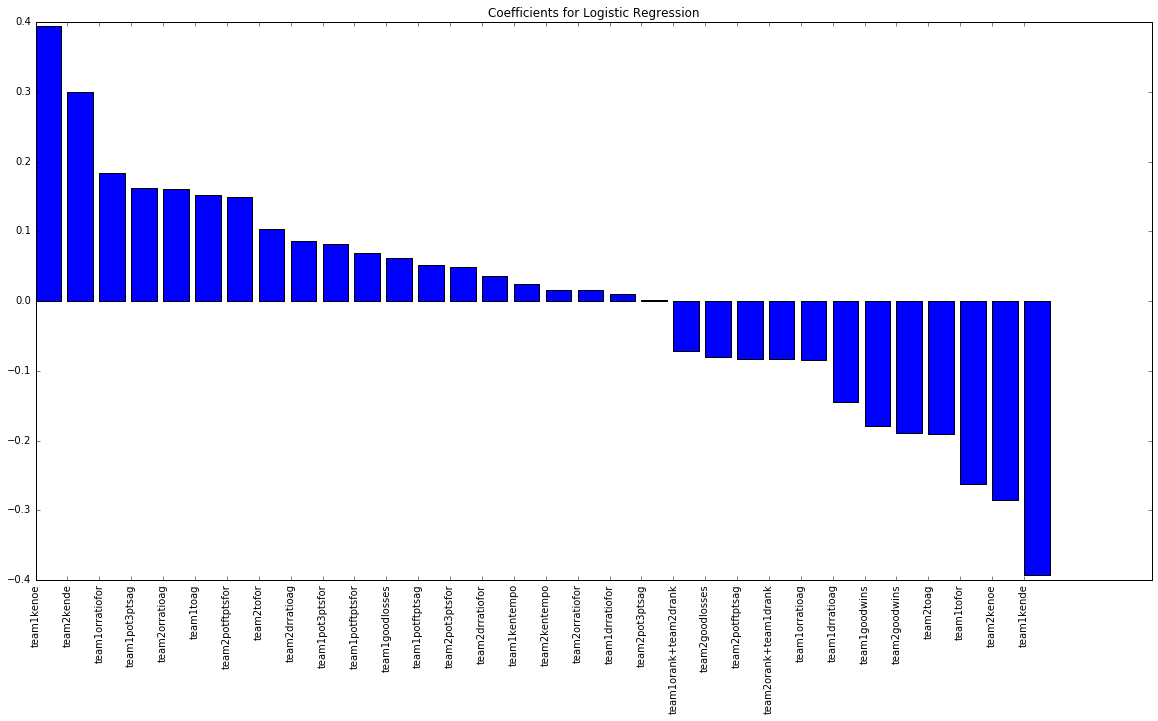

       log_coefs  variables                 LABELS
0   2.474275e-06          0             team1kenoe
1   2.211764e-06          1             team2kende
2   1.955796e-06          2        team1orratiofor
3   1.734150e-06          3        team1drratiofor
4   1.665519e-06          4       team2potftptsfor
5   1.049200e-06          5             team2tofor
6   1.011578e-06          6         team2drratioag
7   8.006180e-07          7       team1potftptsfor
8   7.586782e-07          8         team2orratioag
9   6.586383e-07          9          team2kentempo
10  5.396477e-07         10         team1pot3ptsag
11  3.536179e-07         11              team1toag
12  2.873495e-07         12        team1potftptsag
13  2.664300e-07         13  team2orank+team1drank
14  2.255485e-07         14        team2potftptsag
15  1.883795e-07         15          team1kentempo
16  3.405247e-08         16        team2drratiofor
17 -1.189165e-07         17        team2pot3ptsfor
18 -1.550663e-07         18    

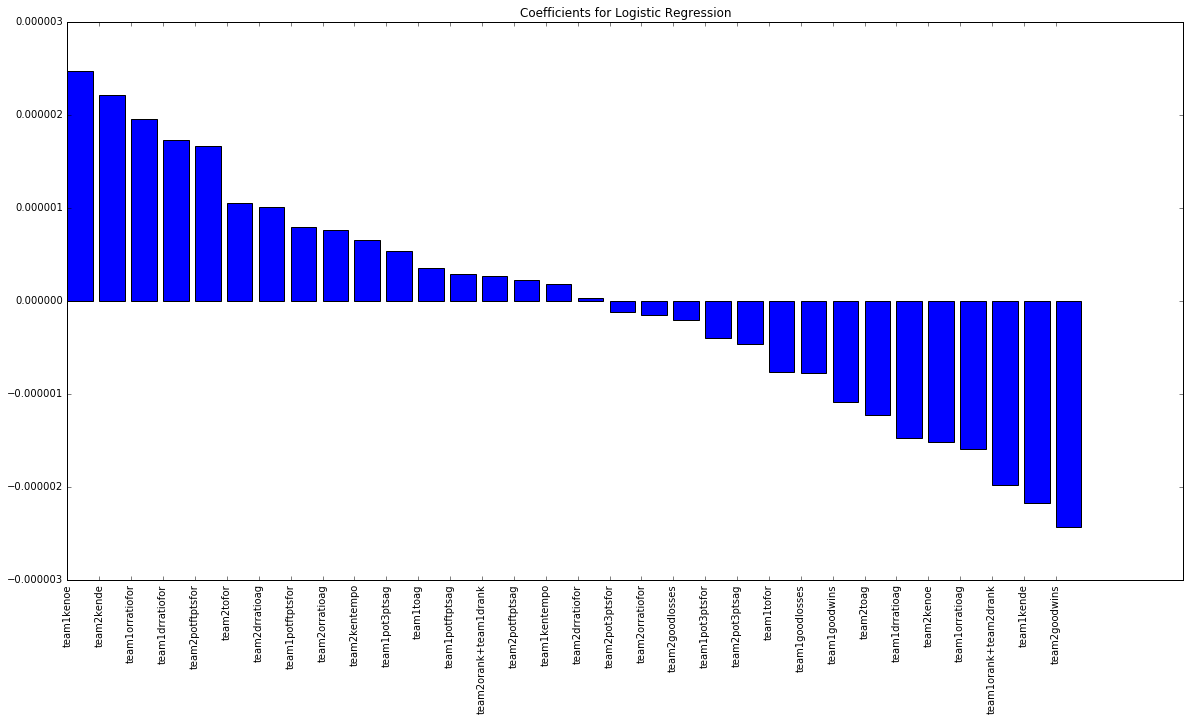

In [44]:
import pylab as plt

def show_coefs(coef_matrix):

    variables = np.array(range(len(coef_matrix)))
    LABELS = predictors_2004_2010.columns.values

    new_df = pd.DataFrame()
    new_df['log_coefs'] = coef_matrix
    new_df['variables'] = variables
    new_df['LABELS'] = LABELS

    new_df = new_df.sort(['log_coefs'], axis = 0, ascending = False)

    new_df = new_df.reset_index()

    new_df = new_df.drop(['index'],axis=1)

    new_df['variables'] = range(len(new_df))
    
    print new_df


    plt.figure(figsize=(20,10))
    plt.bar(new_df['variables'], new_df['log_coefs'])
    plt.title("Coefficients for Logistic Regression")
    plt.xticks(new_df['variables'], new_df['LABELS'], rotation=90)
    # plt.ylim([-0.2,0.3])
    plt.savefig('coefs')
    plt.show()

coef_matrix_1015 = np.concatenate((coef_matrix15,coef_matrix14,coef_matrix13,coef_matrix12,coef_matrix11,coef_matrix10),axis=0)

show_coefs(coef_matrix_1015.mean(axis=0))

coef_matrix_1015_svm = np.concatenate((coef_matrix15_svm,coef_matrix14_svm,coef_matrix13_svm,coef_matrix12_svm,coef_matrix11_svm,coef_matrix10_svm),axis=0)

show_coefs(coef_matrix_1015_svm.mean(axis=0))

In [47]:
print pick_a_bracket(predictions_for_testing15, seeds, bracket_2015, .5, matrix_2015)
print pick_a_bracket(predictions_for_testing14, seeds, bracket_2014, .5, matrix_2014)
print pick_a_bracket(predictions_for_testing13, seeds, bracket_2013, .5, matrix_2013)
print pick_a_bracket(predictions_for_testing12, seeds, bracket_2012, .5, matrix_2012)
print pick_a_bracket(predictions_for_testing11, seeds, bracket_2011, .5, matrix_2011)
print pick_a_bracket(predictions_for_testing10, seeds, bracket_2010, .5, matrix_2010)



['Villanova', 'North Carolina St.', 'Louisville', 'Northern Iowa', 'Providence', 'Oklahoma', 'Michigan St.', 'Virginia', 'Duke', 'San Diego St.', 'Georgetown', 'Utah', 'SMU', 'Iowa St.', 'Iowa', 'Gonzaga', 'Kentucky', 'Cincinnati', 'Maryland', 'West Virginia', 'Butler', 'Notre Dame', 'Wichita St.', 'Kansas', 'Wisconsin', 'Oregon', 'North Carolina', 'Arkansas', 'Xavier', 'Baylor', 'Ohio St.', 'Arizona']
['Villanova', 'Louisville', 'Oklahoma', 'Virginia', 'Duke', 'Georgetown', 'Iowa St.', 'Gonzaga', 'Kentucky', 'West Virginia', 'Notre Dame', 'Kansas', 'Wisconsin', 'North Carolina', 'Baylor', 'Arizona']
['Villanova', 'Virginia', 'Duke', 'Gonzaga', 'Kentucky', 'Kansas', 'Wisconsin', 'Arizona']
['Villanova', 'Duke', 'Kentucky', 'Wisconsin']
['Villanova', 'Kentucky']
['Kentucky']
The amount of correct predictions is 46.0
The score of the bracket was 92
92
['Virginia', 'Memphis', 'Michigan St.', 'Cincinnati', 'North Carolina', 'Iowa St.', 'Connecticut', 'Villanova', 'Florida', 'Colorado', 'UC

In [48]:
print pick_a_bracket(predictions_for_testing15_svm, seeds, bracket_2015, .5, matrix_2015)
print pick_a_bracket(predictions_for_testing14_svm, seeds, bracket_2014, .5, matrix_2014)
print pick_a_bracket(predictions_for_testing13_svm, seeds, bracket_2013, .5, matrix_2013)
print pick_a_bracket(predictions_for_testing12_svm, seeds, bracket_2012, .5, matrix_2012)
print pick_a_bracket(predictions_for_testing11_svm, seeds, bracket_2011, .5, matrix_2011)
print pick_a_bracket(predictions_for_testing10_svm, seeds, bracket_2010, .5, matrix_2010)



['Villanova', 'LSU', 'Louisville', 'Wyoming', 'Providence', 'Oklahoma', 'Michigan St.', 'Virginia', 'Duke', 'San Diego St.', 'Georgetown', 'Utah', 'SMU', 'Iowa St.', 'Iowa', 'Gonzaga', 'Kentucky', 'Cincinnati', 'Valparaiso', 'West Virginia', 'Butler', 'Notre Dame', 'Wichita St.', 'Kansas', 'Wisconsin', 'Oklahoma St.', 'North Carolina', 'Arkansas', 'Xavier', 'Baylor', 'Ohio St.', 'Arizona']
['Villanova', 'Louisville', 'Oklahoma', 'Virginia', 'Duke', 'Georgetown', 'Iowa St.', 'Gonzaga', 'Kentucky', 'West Virginia', 'Butler', 'Kansas', 'Wisconsin', 'North Carolina', 'Baylor', 'Arizona']
['Villanova', 'Virginia', 'Duke', 'Gonzaga', 'Kentucky', 'Kansas', 'Wisconsin', 'Arizona']
['Virginia', 'Duke', 'Kentucky', 'Arizona']
['Virginia', 'Kentucky']
['Virginia']
The amount of correct predictions is 40.0
The score of the bracket was 78
78
['Virginia', 'Memphis', 'Michigan St.', 'Cincinnati', 'North Carolina', 'Iowa St.', 'Connecticut', 'Villanova', 'Florida', 'Colorado', 'UCLA', 'VCU', 'Ohio St.

In [49]:
print pick_a_bracket(predictions_for_testing15_rf, seeds, bracket_2015, .5, matrix_2015)
print pick_a_bracket(predictions_for_testing14_rf, seeds, bracket_2014, .5, matrix_2014)
print pick_a_bracket(predictions_for_testing13_rf, seeds, bracket_2013, .5, matrix_2013)
print pick_a_bracket(predictions_for_testing12_rf, seeds, bracket_2012, .5, matrix_2012)
print pick_a_bracket(predictions_for_testing11_rf, seeds, bracket_2011, .5, matrix_2011)
print pick_a_bracket(predictions_for_testing10_rf, seeds, bracket_2010, .5, matrix_2010)

['Villanova', 'North Carolina St.', 'Louisville', 'Northern Iowa', 'Providence', 'Oklahoma', 'Michigan St.', 'Virginia', 'Duke', 'San Diego St.', 'Georgetown', 'Utah', 'SMU', 'Iowa St.', 'Iowa', 'Gonzaga', 'Kentucky', 'Cincinnati', 'Maryland', 'West Virginia', 'Butler', 'Notre Dame', 'Wichita St.', 'Kansas', 'Wisconsin', 'Oregon', 'North Carolina', 'Arkansas', 'Xavier', 'Baylor', 'VCU', 'Arizona']
['Villanova', 'Louisville', 'Oklahoma', 'Virginia', 'Duke', 'Georgetown', 'Iowa St.', 'Gonzaga', 'Kentucky', 'Maryland', 'Notre Dame', 'Kansas', 'Wisconsin', 'North Carolina', 'Baylor', 'Arizona']
['Villanova', 'Virginia', 'Duke', 'Gonzaga', 'Kentucky', 'Kansas', 'Wisconsin', 'Arizona']
['Villanova', 'Duke', 'Kentucky', 'Wisconsin']
['Villanova', 'Kentucky']
['Villanova']
The amount of correct predictions is 44.0
The score of the bracket was 89
89
['Virginia', 'Memphis', 'Michigan St.', 'Cincinnati', 'North Carolina', 'Iowa St.', 'Connecticut', 'Villanova', 'Florida', 'Colorado', 'UCLA', 'VCU

In [50]:
# Predicts winners of given round of tournament
#
# Input:
#     pred_matrix - output of damn_adventure_time
#     seeds - pre-formatted list of tournament seeds
#     seed_to_name - output of seed_and_name
#     n - number of weighted coin flips 


def pick_winners_binomial(pred_matrix, seeds, seed_to_name, n):
    # counter to track the number of upsets
    upsets = 0
    
    # creates list to hold winners of this round
    winners = []
    
    
    for i in range(0,len(seeds)-1,2):
        
        if(int(seeds[i][-2:]) > int(seeds[i+1][-2:])):
            # adds favorite as winner
            if(np.random.binomial(n,pred_matrix['prediction'][(pred_matrix.iloc[:,1] == seeds[i]) & (pred_matrix.iloc[:,0] == seeds[i+1])].values[0])>(float(n)/2)):            
                winners.append(seeds[i+1])
            # adds underdog as winner
            else:
                winners.append(seeds[i])
                upsets = upsets + 1
        # not exactly sure what this branch is doing
        else:
            if(np.random.binomial(n,pred_matrix['prediction'][(pred_matrix.iloc[:,0] == seeds[i]) & (pred_matrix.iloc[:,1] == seeds[i+1])].values[0])>(float(n)/2)):
                winners.append(seeds[i])
            else:
                winners.append(seeds[i+1])
                upsets = upsets + 1
    
    # create list to hold name of round winners
    winners_name = []
    
    
    for i in range(len(winners)):
        winners_name.append(seed_to_name.iloc[:,1][seed_to_name.iloc[:,0] == winners[i]].values[0])

    #print winners_name
    return winners
           

In [51]:
def pick_a_bracket_binomial(predictions_for_testing, seeds, bracket, matrix_year, n):

    round1winners = pick_winners_binomial(predictions_for_testing, seeds, bracket, n)
    round2winners = pick_winners_binomial(predictions_for_testing, round1winners, bracket, n)
    round3winners = pick_winners_binomial(predictions_for_testing, round2winners, bracket, n)
    round4winners = pick_winners_binomial(predictions_for_testing, round3winners, bracket, n)
    round5winners = pick_winners_binomial(predictions_for_testing, round4winners, bracket, n)
    round6winners = pick_winners_binomial(predictions_for_testing, round5winners, bracket, n)
    
    pred_winners = pd.Series(np.concatenate((round1winners,round2winners,round3winners,round4winners,round5winners,round6winners),axis=0))

    games_played = pd.concat([matrix_year['team1spot'],matrix_year['team2spot']],axis=0)

    games_won_by_team_2015 = games_played.value_counts()-1

    preds_won_by_team_2015 = pred_winners.value_counts()

    actual_and_prediction_wins = pd.concat([games_won_by_team_2015, preds_won_by_team_2015], axis=1)

    actual_and_prediction_wins = actual_and_prediction_wins.fillna(0)

    right_predictions = 0
    score_bracket = 0
    for i in range(len(actual_and_prediction_wins)):
        right_predictions = right_predictions + np.min(actual_and_prediction_wins.iloc[i,:])
        score_add = 0
        if (np.min(actual_and_prediction_wins.iloc[i,:])>0):
            for j in range(int(np.min(actual_and_prediction_wins.iloc[i,:]))):
                score_add = 2**j + score_add
            score_bracket = score_bracket + score_add

    return score_bracket

In [52]:
odd_votes = range(1,25,2)

score_ranges_log = np.zeros((len(odd_votes),10))
score_ranges_svm = np.zeros((len(odd_votes),10))
score_ranges_rf = np.zeros((len(odd_votes),10))



for i in odd_votes:
    for j in range(10):

        score_ranges_log[(i-1)/2,j] = pick_a_bracket_binomial(predictions_for_testing15, seeds, bracket_2015, matrix_2015, i)

for i in odd_votes:
    for j in range(10):

        score_ranges_svm[(i-1)/2,j] = pick_a_bracket_binomial(predictions_for_testing15_svm, seeds, bracket_2015, matrix_2015, i)

for i in odd_votes:
    for j in range(10):

        score_ranges_rf[(i-1)/2,j] = pick_a_bracket_binomial(predictions_for_testing15_rf, seeds, bracket_2015, matrix_2015, i)

        
print score_ranges_log , score_ranges_svm , score_ranges_rf 

[[  90.   71.   86.   84.   76.   66.   79.   49.   72.   73.]
 [  74.   68.   89.   99.   84.   67.   87.  102.   72.  107.]
 [ 101.   88.   83.   91.  110.   79.   84.  110.   88.   95.]
 [  81.   89.   90.   88.  103.  122.   89.   83.   90.  103.]
 [  90.  106.   93.   85.   97.   88.   86.   90.   85.   89.]
 [  84.  104.  107.   90.   86.   82.  108.  107.  106.   90.]
 [  81.   94.  104.  102.   86.   88.  105.   89.  106.   96.]
 [ 121.   85.   89.   97.   90.  100.   86.   84.   92.  120.]
 [  82.   98.   89.   93.   89.  122.   89.   91.   91.   87.]
 [  90.   98.  108.  106.  105.   90.   86.   95.  105.  104.]
 [ 105.   90.   89.   92.   90.   90.   91.   91.   91.   94.]
 [  89.   92.  107.  107.   90.   91.  106.   92.   87.   92.]] [[  65.   55.   88.   82.   59.   83.   65.   66.   70.   66.]
 [  78.   85.   94.   93.   77.   62.   72.   77.   89.   85.]
 [  74.   87.   80.   75.   88.   87.   73.   94.   95.   94.]
 [  87.   90.   76.   79.  107.   69.   76.   78.   75

[  96.  111.   91.  126.  110.  107.  112.  123.  112.  107.  115.  106.] [  98.  129.  105.   96.  108.   95.   94.   90.  102.   91.  105.   91.] [  87.   90.   92.  128.  105.  102.   96.  106.  116.   98.  124.  110.]


(array([ 1.,  1.,  1.,  2.,  0.,  1.,  0.,  1.,  1.,  1.,  0.,  0.,  0.,
         0.,  1.]),
 array([  72.        ,   74.53333333,   77.06666667,   79.6       ,
          82.13333333,   84.66666667,   87.2       ,   89.73333333,
          92.26666667,   94.8       ,   97.33333333,   99.86666667,
         102.4       ,  104.93333333,  107.46666667,  110.        ]),
 <a list of 15 Patch objects>)

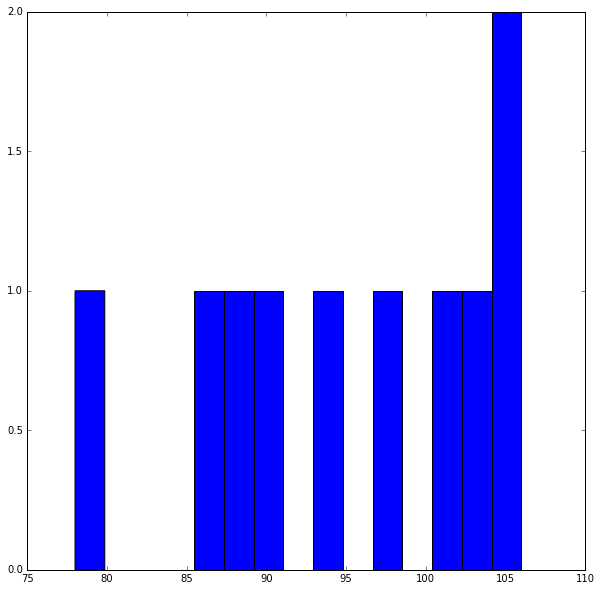

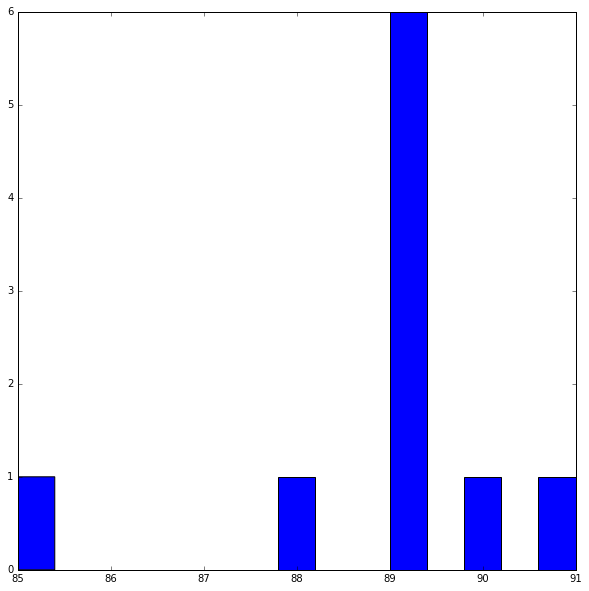

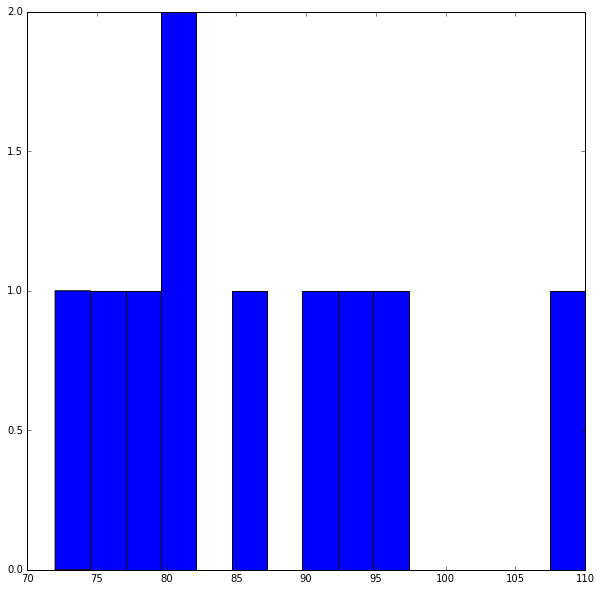

In [129]:
print score_ranges_log.max(axis=1) , score_ranges_svm.max(axis=1) , score_ranges_rf.max(axis=1) 

fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(111)
ax1.hist(score_ranges_log[11,:], bins=15)

fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(111)
ax1.hist(score_ranges_svm[11,:], bins=15)

fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(111)
ax1.hist(score_ranges_rf[11,:], bins=15)

In [53]:
all_brackets = [bracket_2010,bracket_2011,bracket_2012,bracket_2013,bracket_2014,bracket_2015]
all_matrices = [matrix_2010,matrix_2011,matrix_2012,matrix_2013,matrix_2014,matrix_2015]
all_predictions_for_testing_log = [predictions_for_testing10,predictions_for_testing11,predictions_for_testing12,
                               predictions_for_testing13,predictions_for_testing14,predictions_for_testing15]

all_predictions_for_testing_svm = [predictions_for_testing10_svm,predictions_for_testing11_svm,predictions_for_testing12_svm,
                               predictions_for_testing13_svm,predictions_for_testing14_svm,predictions_for_testing15_svm]

all_predictions_for_testing_rf = [predictions_for_testing10_rf,predictions_for_testing11_rf,predictions_for_testing12_rf,
                               predictions_for_testing13_rf,predictions_for_testing14_rf,predictions_for_testing15_rf]



score_ranges_log = np.zeros((6,250))
score_ranges_svm = np.zeros((6,250))
score_ranges_rf = np.zeros((6,250))




for i in range(len(score_ranges_log)):
    for j in range(250):

        score_ranges_log[i,j] = pick_a_bracket_binomial(all_predictions_for_testing_log[i], seeds, all_brackets[i], all_matrices[i], 1)
        score_ranges_svm[i,j] = pick_a_bracket_binomial(all_predictions_for_testing_svm[i], seeds, all_brackets[i], all_matrices[i], 1)
        score_ranges_rf[i,j] = pick_a_bracket_binomial(all_predictions_for_testing_rf[i], seeds, all_brackets[i], all_matrices[i], 1)


print score_ranges_log

print score_ranges_svm

print score_ranges_rf

[[ 46.  46.  48. ...,  83.  49.  65.]
 [ 33.  43.  37. ...,  35.  40.  43.]
 [ 52.  58.  38. ...,  78.  65.  71.]
 [ 73.  94.  49. ...,  90.  74.  48.]
 [ 48.  47.  47. ...,  67.  60.  51.]
 [ 79.  71.  83. ...,  75.  64.  70.]]
[[  62.   67.   52. ...,   64.   60.   56.]
 [  56.   45.   56. ...,   45.   57.   47.]
 [  84.   88.   79. ...,   98.   77.   88.]
 [  65.   55.   59. ...,   79.   57.   73.]
 [  55.   49.   61. ...,   45.   52.   47.]
 [  53.   58.   88. ...,   70.   79.  106.]]
[[ 40.  65.  64. ...,  36.  52.  85.]
 [ 54.  58.  57. ...,  65.  58.  47.]
 [ 46.  56.  56. ...,  45.  56.  61.]
 [ 83.  57.  76. ...,  56.  45.  56.]
 [ 52.  36.  47. ...,  39.  57.  38.]
 [ 42.  54.  43. ...,  79.  86.  59.]]


In [54]:
print score_ranges_rf.max(axis=1)
print score_ranges_log.max(axis=1)
print score_ranges_svm.max(axis=1)

[  91.   88.  122.  113.   74.  124.]
[  92.   83.  115.  112.   74.  122.]
[  94.   85.  119.  102.   83.  122.]


**2016 Predictions**

In [55]:
def matchups_matrix_2016(info2016):
    # creates dataframe to hold all possible seed matchups
    preds_all_games = pd.DataFrame(np.zeros((64**2,2)))

    # creates counter for indexing
    count = 0
    
    # inserts all possible combinations of seeds into preds_all_games
    for i in range(len(info2016)):
        for j in range(len(info2016)):
            preds_all_games.ix[count,0] = info2016['team1spot'].iloc[i]
            preds_all_games.ix[count,1] = info2016['team1spot'].iloc[j]
            count = count + 1
    
    # creates two new dataframes to hold predictors for each team
    favorites = pd.DataFrame(np.zeros((64**2,15)))
    underdogs = pd.DataFrame(np.zeros((64**2,15)))

    # retrieves predictors for the favorites and underdogs
    for i in range(0,64**2):
        favorites.iloc[i,:] = pd.Series(info2016.iloc[:,range(15)][info2016['team1spot']==preds_all_games.iloc[i,0]].values[0])
        underdogs.iloc[i,:] = pd.Series(info2016.iloc[:,range(15)][info2016['team1spot']==preds_all_games.iloc[i,1]].values[0])
    
    
    interaction_terms = pd.DataFrame(np.zeros((64**2,2)))
    for i in range(0,64**2):
        interaction_terms.iloc[i,0] = favorites.iloc[i,12] * underdogs.iloc[i,11]
        interaction_terms.iloc[i,1] = underdogs.iloc[i,12] * favorites.iloc[i,11]
        #interaction_terms.iloc[i,2] =  favorites.iloc[i,13] * underdogs.iloc[i,13]    
        #interaction_terms.iloc[i,3] = favorites.iloc[i,14] * underdogs.iloc[i,15]    
        #interaction_terms.iloc[i,4] = favorites.iloc[i,15] * underdogs.iloc[i,14]
    # concatenates all dataframes together
    preds_all_games_final = pd.concat([preds_all_games, favorites, underdogs,
                                            interaction_terms], axis=1)
    
    # renames columns
    preds_all_games_final.columns = ["favorite", "underdog",'team1tofor', 'team1drratiofor', 'team1orratiofor', 
'team1pot3ptsfor',
 'team1potftptsfor', 'team1toag' ,'team1drratioag', 'team1orratioag',
 'team1pot3ptsag' ,'team1potftptsag', 'team1kentempo' ,'team1drank',
 'team1orank' ,
#'team1seed', 
'team1goodwins', 'team1goodlosses', 'team2tofor',
 'team2drratiofor', 'team2orratiofor', 'team2pot3ptsfor' ,'team2potftptsfor',
 'team2toag' ,'team2drratioag', 'team2orratioag' ,'team2pot3ptsag',
 'team2potftptsag', 'team2kentempo' ,'team2drank', 'team2orank', 
#'team2seed',
 'team2goodwins' ,'team2goodlosses', 'team1orank+team2drank',
 'team2orank+team1drank']
#'team1seed+team2seed']
    
    return preds_all_games_final

In [56]:
info2016 = pd.read_csv("info2016.csv")

matchups_2016 = matchups_matrix_2016(info2016)

In [57]:
predictions_for_testing16, coef_matrix16 = damn_adventure_time(matchups_2016.iloc[:,range(32+2)], predictors_2009_2015, response_2009_2015, .1)
predictions_for_testing16_svm, coef_matrix16_svm = damn_adventure_time_svm(matchups_2016.iloc[:,range(32+2)], predictors_2009_2015, response_2009_2015, 10**-7)

predictions_for_testing16_rf, importance16 = damn_adventure_time_rf(matchups_2016.iloc[:,range(32+2)], predictors_2009_2015, response_2009_2015, 4, 6)

In [58]:
bracket_2016 = seed_and_name(seeds, info2016)

In [59]:
team_wins_2016 = pd.Series(['W01','W01','W01','W01','W01','W09','W05','W05','W04','W06','W06','W06','W14','W07','W07','W02',
                 'X01','X01','X01','X10','X10','X10','X10','X11','X11','X12','X03','X04','X04','X15','X09',
                 'Y02','Y02','Y02','Y02','Y02','Y02','Y01','Y01','Y01','Y05','Y05','Y13','Y11','Y07','Y03','Y03','Y09',
                 'Z01','Z01','Z01','Z02','Z02','Z02','Z02','Y03','Y03','Y04','Y04','Y08','Y10','Y11','Y12' ])

In [60]:
def pick_a_bracket_binomial_2016(predictions_for_testing, seeds, bracket, n, team_wins_2016):

    round1winners = pick_winners_binomial(predictions_for_testing, seeds, bracket, n)
    round2winners = pick_winners_binomial(predictions_for_testing, round1winners, bracket, n)
    round3winners = pick_winners_binomial(predictions_for_testing, round2winners, bracket, n)
    round4winners = pick_winners_binomial(predictions_for_testing, round3winners, bracket, n)
    round5winners = pick_winners_binomial(predictions_for_testing, round4winners, bracket, n)
    round6winners = pick_winners_binomial(predictions_for_testing, round5winners, bracket, n)
    
    pred_winners = pd.Series(np.concatenate((round1winners,round2winners,round3winners,round4winners,round5winners,round6winners),axis=0))
                        
    games_won_by_team_2016 = team_wins_2016.value_counts()

    preds_won_by_team_2016 = pred_winners.value_counts()

    actual_and_prediction_wins = pd.concat([games_won_by_team_2016, preds_won_by_team_2016], axis=1)

    actual_and_prediction_wins = actual_and_prediction_wins.fillna(0)

    right_predictions = 0
    score_bracket = 0
    for i in range(len(actual_and_prediction_wins)):
        right_predictions = right_predictions + np.min(actual_and_prediction_wins.iloc[i,:])
        score_add = 0
        if (np.min(actual_and_prediction_wins.iloc[i,:])>0):
            for j in range(int(np.min(actual_and_prediction_wins.iloc[i,:]))):
                score_add = 2**j + score_add
            score_bracket = score_bracket + score_add

    return score_bracket

score_ranges_log = np.zeros((1,250))
score_ranges_svm = np.zeros((1,250))
score_ranges_rf = np.zeros((1,250))





for j in range(250):

    score_ranges_log[0,j] = pick_a_bracket_binomial_2016(predictions_for_testing16, seeds, bracket_2016, 1, team_wins_2016)
    score_ranges_svm[0,j] = pick_a_bracket_binomial_2016(predictions_for_testing16_svm, seeds, bracket_2016, 1, team_wins_2016)
    score_ranges_rf[0,j] = pick_a_bracket_binomial_2016(predictions_for_testing16_rf, seeds, bracket_2016,  1, team_wins_2016)



(array([  7.,  23.,  47.,  42.,  38.,  30.,  27.,  16.,   8.,   6.,   3.,
          2.,   0.,   0.,   1.]),
 array([  19.        ,   26.73333333,   34.46666667,   42.2       ,
          49.93333333,   57.66666667,   65.4       ,   73.13333333,
          80.86666667,   88.6       ,   96.33333333,  104.06666667,
         111.8       ,  119.53333333,  127.26666667,  135.        ]),
 <a list of 15 Patch objects>)

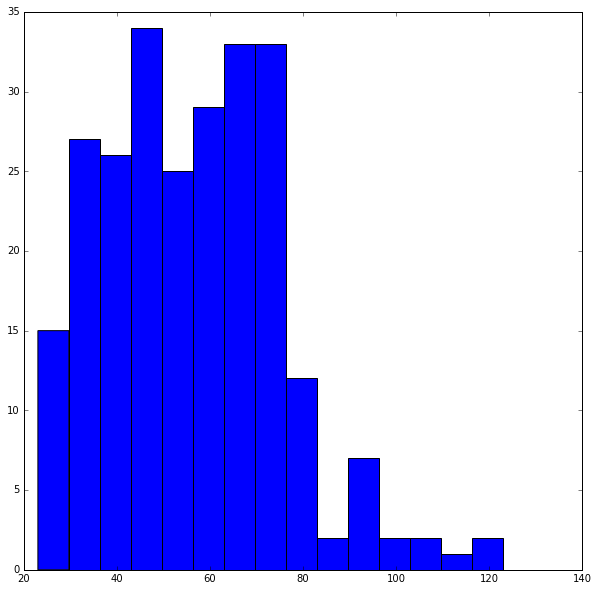

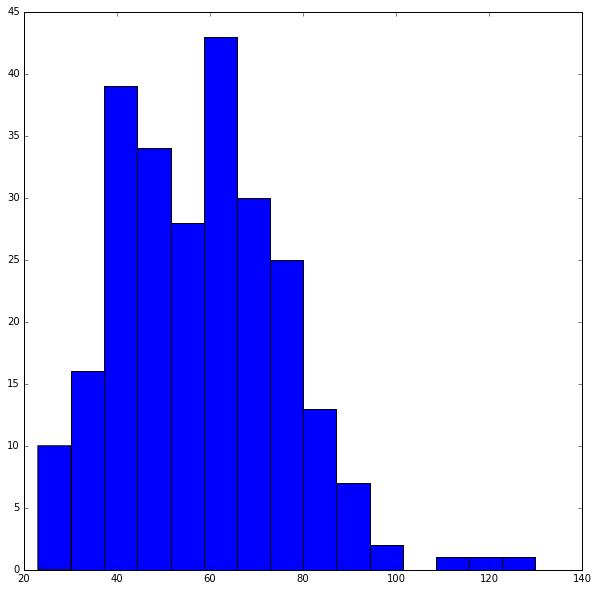

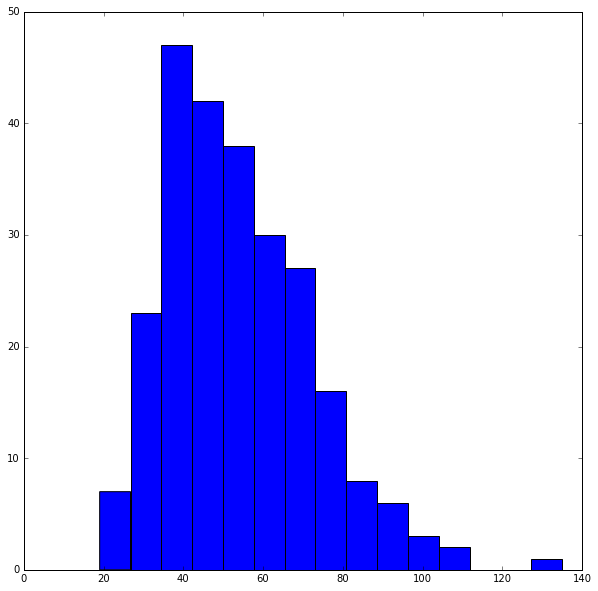

In [61]:
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(111)
ax1.hist(score_ranges_log[0,:], bins=15)

fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(111)
ax1.hist(score_ranges_svm[0,:], bins=15)

fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(111)
ax1.hist(score_ranges_rf[0,:], bins=15)

In [62]:
print score_ranges_rf.max(axis=1)
print score_ranges_log.max(axis=1)
print score_ranges_svm.max(axis=1)

[ 135.]
[ 123.]
[ 130.]
